In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.datasets import make_moons, make_circles, make_blobs

class Layer:
    def __init__(self):
        self.trainable = True
        self.built = False
        self.previous = None
        self.inputs = None

    def __call__(self, inputs):
        self.previous = inputs
        return self
    
    def build(self, inputs):
        pass

    def forward(self, inputs):
        raise NotImplementedError
        
    def backward(self, grad):
        raise NotImplementedError

class Input(Layer):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, inputs):
        return inputs

    def __call__(self, inputs=None):
        return self

class Model:
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        self.loss = []
        self.loss_fn = None
        self.learning_rate = None
        self.layers = self._extract_layers(inputs, outputs)

    def _extract_layers(self, inputs, outputs):
        '''
        This is the main first difference. We need a `self.previous` in each Layer object so
        that we can build the `self.layers` list and iterate through it like in the Sequential
        model example. This function is executed until the current layer is an input layer,
        and then we add the input layer after the while loop. 
        '''
        layers = []
        current_layer = outputs
        while current_layer != inputs:
            layers.insert(0, current_layer)
            current_layer = current_layer.previous
        layers.insert(0, inputs)
        return layers

    def compile(self, loss, learning_rate):
        '''
        Small compile function to look more like a Model API.
        '''
        self.loss_fn = loss
        self.learning_rate = learning_rate

    def predict(self, X):
        '''
        Note, we will need to `build` the model now to register the attributes (see Linear below).
        In this case, we first check if it is built. If not, build the layer and set it to True,
        otherwise, do the forward pass. 
        '''
        layer_output = X
        for layer in self.layers:
            if not layer.built:
                layer.build(layer_output)
                layer.built = True
            layer_output = layer.forward(layer_output)
        return layer_output

    def fit(self, X_train, Y_train, epochs, verbose=False):
        '''
        Very similar to the Sequential model. Note we must check if its built. 
        '''
        for epoch in range(epochs):
            loss = self._fit_on_epoch(X_train, Y_train)
            if verbose and epoch % 500 == 0:
                print(f'Epoch: {epoch}. Loss: {loss}')

    def _fit_on_epoch(self, X, Y):
        forward = X
        for layer in self.layers:
            if not layer.built:
                layer.build(forward)
                layer.built = True
            forward = layer.forward(forward)

        error = self.loss_fn.forward(forward, Y)
        gradient = self.loss_fn.backward()
        self.loss.append(error)

        for layer in reversed(self.layers):
            if isinstance(layer, Linear):
                gradient, grad_weights, grad_bias = layer.backward(gradient)
                layer.apply_gradients(grad_weights, grad_bias, self.learning_rate)
            elif isinstance(layer, Input):
                pass
            else:
                gradient = layer.backward(gradient)

        return error

class Linear(Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, inputs):
        '''
        This is the main difference with the Sequential Model's version of the Linear Layer (previous notebook).
        We initialise the weights and biases, and set the input shape. 
        Note only the Linear layer has weights, and the first layer will be a Linear layer. So the others do not 
        really need a build method, e.g., there is nothing additional we need before we can apply an activation
        to the output of the Linear layer. The parent class has a build method which passes it, so all other layers
        will inheret this unless we specifically make a build method for a subclass. 
        '''
        self.input_dim = inputs.shape[1]
        self.weights = np.random.randn(self.input_dim, self.units)
        self.bias = np.zeros((1, self.units))

    def forward(self, inputs):
        self.inputs = inputs
        return np.matmul(inputs, self.weights) + self.bias
    
    def backward(self, grad):
        grad_inputs = np.matmul(grad, self.weights.T)
        grad_weights = np.matmul(self.inputs.T, grad)
        grad_bias = np.sum(grad, axis=0, keepdims=True)
        return grad_inputs, grad_weights, grad_bias

    def apply_gradients(self, grad_weights, grad_bias, lr):
        if self.trainable:
            self.weights -= lr * grad_weights
            self.bias -= lr * grad_bias

class ReLU(Layer):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad):
        grad_inputs = grad * (self.inputs > 0)
        return grad_inputs

class MeanSquaredError:
    '''
    This is the Mean Absolute Error Loss. Note we also treat it as a layer. 
    However, the forward and backward methods work slightly differently.
    Try make your own Loss class which has a different forward and backward pass to 
    take into account that the targets must be given for the forward pass, 
    and that no gradient is required to start the backward pass. 
    '''
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        return 0.5 * np.mean((inputs - targets) ** 2)
    
    def backward(self):
        return (self.inputs - self.targets) / self.inputs.shape[0]
    
class MeanAbsoluteError(Layer):
    '''
    This is the Mean Absolute Error Loss. Note we also treat it as a layer. 
    However, the forward and backward methods work slightly differently.
    '''
    def forward(self, inputs, targets):
        self.inputs = inputs # Predictions
        self.targets = targets # Labels
        return np.mean(np.abs(inputs - targets))
    
    def backward(self):
        return np.sign(self.inputs - self.targets) / self.inputs.shape[0]

class Sigmoid(Layer):
    '''
    This is the Sigmoid activation function. 
    '''
    def forward(self, inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        return self.outputs
    
    def backward(self, grad):
        grad_inputs = grad * self.outputs * (1 - self.outputs)
        return grad_inputs

class BinaryCrossEntropy(Layer):
    '''
    This is the binary cross-entropy loss function.
    It assumes that both "inputs" and "targets" are column vectors. 
    '''
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.eps = 1e-8 # Added to avoid log(0)
        return -np.mean(targets * np.log(inputs + self.eps) + (1 - targets) * np.log(1 - inputs + self.eps))
    
    def backward(self):
        return (self.inputs - self.targets) / (self.inputs * (1 - self.inputs) + self.eps) / self.inputs.shape[0]

class SoftMax(Layer):
    '''
    This is the softmax activation function. 
    Note it is programmed to only be used with the categorical cross-entropy loss. 
    NOTE: we compute dL/dZ directly in the CrossEntropyLoss, so the gradient here 
    just passes back the gradient of L with respect to Z, the inputs to this layer.
    So if we had Z -> A = SoftMax(Z) -> L = CrossEntropyLoss, then we should actually first
    find dL/dA, backprop, and then use it to find dL/dZ. However, for the sake of example,
    we compute dL/dZ directly (in the CrossEntropyLoss) because of its simple form 
    of dL/dZ = A - Y.
    '''
    def forward(self, inputs):
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.outputs = exps / np.sum(exps, axis=1, keepdims=True)
        return self.outputs
    
    def backward(self, grad):
        return grad

class CategoricalCrossEntropy(Layer):
    '''
    This is the categorical cross-entropy loss. 
    It is assumed that both "inputs" and "targets" are matrices of shape (batch_size, n_classes).
    '''
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.eps = 1e-8
        return -np.mean(np.sum(targets * np.log(inputs + self.eps), axis=1))
    
    def backward(self):
        return (self.inputs - self.targets) / self.inputs.shape[0]
    
def generate_regression_data(n, scale=0.25, seed=4433):
    np.random.seed(seed)
    x = np.random.uniform(-3, 3, (n,))
    err = np.random.normal(0., scale, (n,))
    y = 0.2 * x**3 + 0.8 * x**2 + 1 + err
    
    mux = np.mean(x)
    muy = np.mean(y)
    sigx = np.std(x)
    sigy = np.std(y)
    x = (x - mux) / sigx
    y = (y - muy) / sigy
    return x, y

def one_hot_encode(labels, num_classes=None):
    # Find the number of classes if not provided
    if num_classes is None:
        num_classes = np.max(labels) + 1

    # Create a matrix of zeros
    one_hot_labels = np.zeros((labels.shape[0], num_classes))

    # Set the appropriate elements to 1
    one_hot_labels[np.arange(labels.shape[0]), labels] = 1

    return one_hot_labels

def generate_multiclass_data(n, n_classes, seed=9090, cluster_std=3.5):
    np.random.seed(seed)
    X, y = make_blobs(n_samples=n, centers=n_classes, n_features=2, cluster_std=cluster_std)
    return X,y

def plot_2D_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)
    y_pred = y_prob.argmax(axis=1).reshape(xx.shape)
    
    plt.figure()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

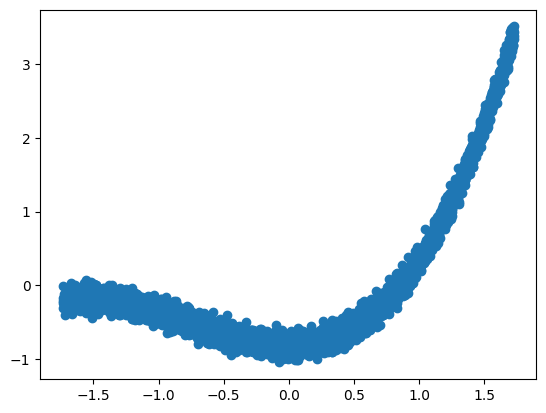

In [2]:
x, y = generate_regression_data(5000)

plt.figure()
plt.scatter(x, y)
plt.show()

In [3]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [4]:
input_layer = Input(shape=(1,))
layer1 = Linear(16)(input_layer)
layer2 = ReLU()(layer1)
layer3 = Linear(16)(layer2)
layer4 = ReLU()(layer3)
layer5 = Linear(16)(layer4)
layer6 = ReLU()(layer5)
output_layer = Linear(1)(layer6)

In [5]:
my_model = Model(inputs=input_layer, outputs=output_layer)
my_model.compile(loss=MeanSquaredError(), learning_rate=0.004)
my_model.fit(X_train=x, Y_train=y, epochs=3000, verbose=True)

Epoch: 0. Loss: 69.51598724103836
Epoch: 500. Loss: 0.01433657453317291
Epoch: 1000. Loss: 0.009939064231304277
Epoch: 1500. Loss: 0.007408715636712747
Epoch: 2000. Loss: 0.005965598043037375
Epoch: 2500. Loss: 0.0052280133877563315


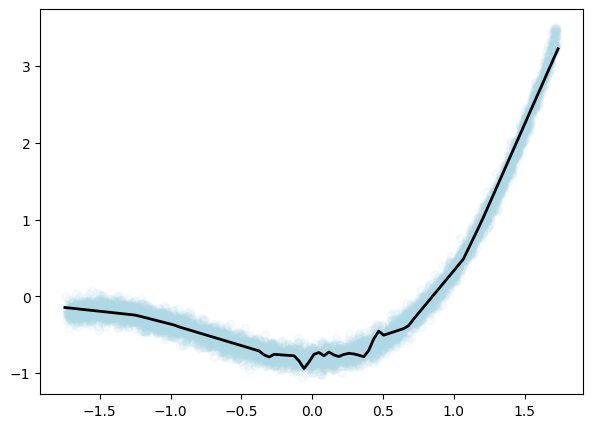

In [6]:
xseq = np.linspace(x.min()-1e-02, x.max()+1e-02, 100).reshape(-1, 1)
yseq = my_model.predict(xseq)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, color='lightblue', alpha=0.1)
plt.plot(xseq, yseq.ravel(), color='black', linewidth=2.0)
plt.show()

In [7]:
input_layer = Input(shape=(1,))
layer1 = Linear(16)(input_layer)
layer2 = ReLU()(layer1)
layer3 = Linear(16)(layer2)
layer4 = ReLU()(layer3)
layer5 = Linear(16)(layer4)
layer6 = ReLU()(layer5)
output_layer = Linear(1)(layer6)

my_model = Model(inputs=input_layer, outputs=output_layer)
my_model.compile(loss=MeanAbsoluteError(), learning_rate=0.004)
my_model.fit(X_train=x, Y_train=y, epochs=3000, verbose=True)

Epoch: 0. Loss: 5.247280317006621
Epoch: 500. Loss: 0.21473547716743088
Epoch: 1000. Loss: 0.18778260247575823
Epoch: 1500. Loss: 0.13230874573233842
Epoch: 2000. Loss: 0.1097357222297343
Epoch: 2500. Loss: 0.09538132878197701


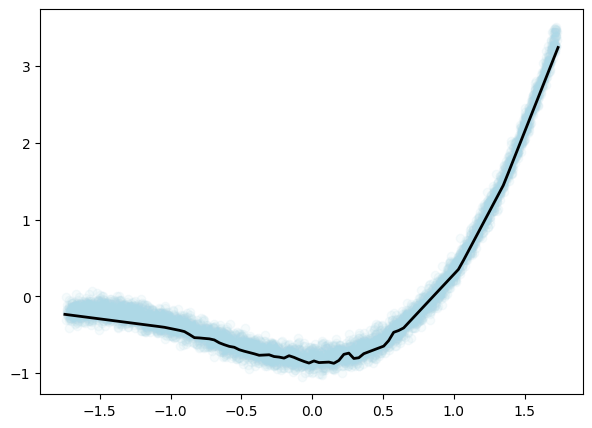

In [8]:
xseq = np.linspace(x.min()-1e-02, x.max()+1e-02, 100).reshape(-1, 1)
yseq = my_model.predict(xseq)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, color='lightblue', alpha=0.1)
plt.plot(xseq, yseq.ravel(), color='black', linewidth=2.0)
plt.show()

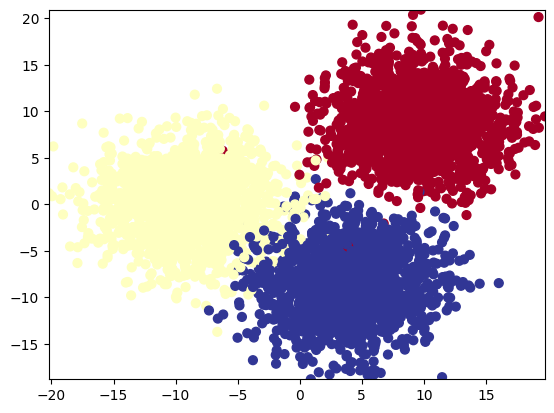

In [9]:
n_classes = 3

X, y = generate_multiclass_data(5000, n_classes)

# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
plt.figure()
plt.scatter(df.x, df.y, c=df.label, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(df.x.min(), df.x.max())
plt.ylim(df.y.min(), df.y.max())
plt.show()

Y = one_hot_encode(y, n_classes)

In [10]:
input_layer = Input(shape=(2,))
layer1 = Linear(16)(input_layer)
layer2 = ReLU()(layer1)
layer3 = Linear(16)(layer2)
layer4 = ReLU()(layer3)
layer5 = Linear(16)(layer4)
layer6 = ReLU()(layer5)
layer7 = Linear(3)(layer6)
output_layer = SoftMax()(layer7)

my_model = Model(inputs=input_layer, outputs=output_layer)

In [11]:
my_model.compile(loss=CategoricalCrossEntropy(), learning_rate=0.003)

In [12]:
my_model.fit(X_train=X, Y_train=Y, epochs=3000, verbose=True)

Epoch: 0. Loss: 9.030343497420398
Epoch: 500. Loss: 0.10793799872567868
Epoch: 1000. Loss: 0.10220608889668546
Epoch: 1500. Loss: 0.17329072878347068
Epoch: 2000. Loss: 0.10970674089795648
Epoch: 2500. Loss: 0.20346373154845532


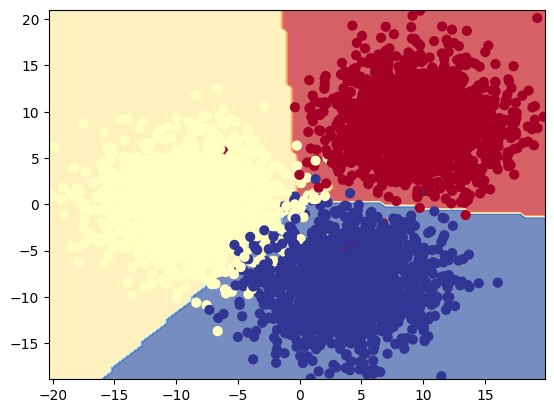

In [13]:
plot_2D_decision_boundary(X,y,my_model)

In [14]:
n_samples = 3000

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.15, random_state=170)

In [15]:
df_moon = pd.DataFrame(noisy_moons[0], columns = ['X1', 'X2'])
df_moon['Y'] = noisy_moons[1]

<Axes: xlabel='X1', ylabel='X2'>

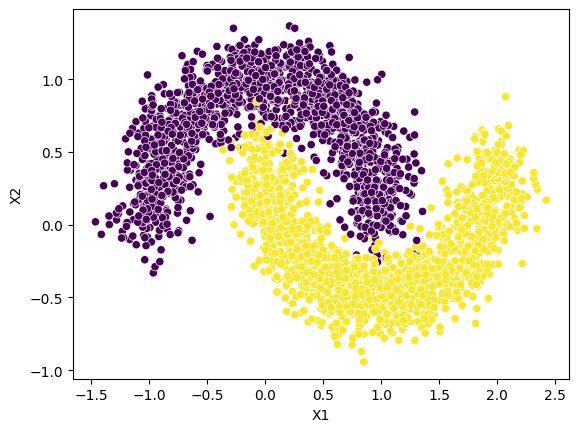

In [16]:
sns.scatterplot(x='X1', y='X2', c = df_moon['Y'].values, data=df_moon)

In [17]:
X = df_moon.iloc[:,:2].values
Y = df_moon.iloc[:,2].values

Y = Y.reshape(-1,1)

In [18]:
input_layer = Input(shape=(2,))

layer1 = Linear(64)(input_layer)
layer2 = ReLU()(layer1)
layer3 = Linear(64)(layer2)
layer4 = ReLU()(layer3)
layer5 = Linear(1)(layer4)
output_layer = Sigmoid()(layer5)

my_model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
my_model.compile(loss=BinaryCrossEntropy(), learning_rate=0.003)

In [20]:
my_model.fit(X_train=X, Y_train=Y, epochs=3000, verbose=True)

Epoch: 0. Loss: 5.274859411410913
Epoch: 500. Loss: 0.11549885067102841
Epoch: 1000. Loss: 0.06558825868372581
Epoch: 1500. Loss: 0.0519643767146218
Epoch: 2000. Loss: 0.04576899105598979
Epoch: 2500. Loss: 0.041827182532353575


In [21]:
probs = my_model.predict(X)
preds = [1 if p>0.5 else 0 for p in probs]

In [22]:
def plot_2D_binary_decision_boundary(X, y, model):
    # Define the grid for plotting
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)  # Predict probabilities
    y_pred = (y_prob > 0.5).astype(int).reshape(xx.shape)  # Convert to binary class predictions
    
    plt.figure()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolor='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

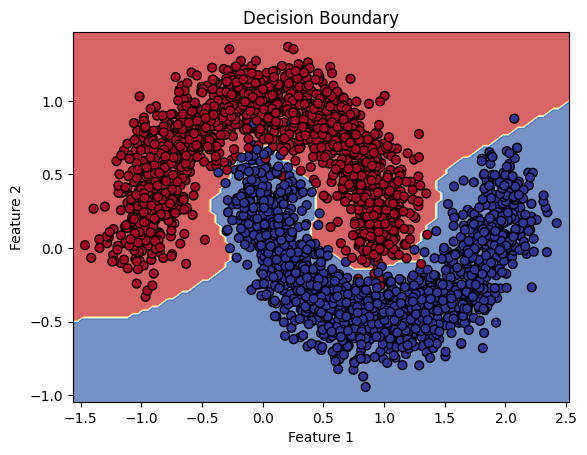

In [23]:
plot_2D_binary_decision_boundary(X,Y,my_model)

# Let's batch the data too

Note that in practice we will use a `tf.keras.data.Dataset` object which **does not** form part of the `Model` or `Layer` classes. For simplicitly, I will include it in the `Model` class here so that we can create the batches when calling the `fit` method. Try to create your own class for a data pipeline and update the `Model` class. 

In [28]:
class Model:
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        self.loss = []
        self.loss_fn = None
        self.learning_rate = None
        self.layers = self._extract_layers(inputs, outputs)

    def _extract_layers(self, inputs, outputs):
        layers = []
        current_layer = outputs
        while current_layer != inputs:
            layers.insert(0, current_layer)
            current_layer = current_layer.previous
        layers.insert(0, inputs)
        return layers

    def compile(self, loss, learning_rate):
        self.loss_fn = loss
        self.learning_rate = learning_rate

    def predict(self, X):
        layer_output = X
        for layer in self.layers:
            if not layer.built:
                layer.build(layer_output)
                layer.built = True
            layer_output = layer.forward(layer_output)
        return layer_output

    def fit(self, X_train, Y_train, epochs, batch_size, verbose=False):
        for epoch in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            Y_train_shuffled = Y_train[indices]
            # NOTE - FIT ON BATCH NOW
            # Loop over batches
            for X_batch, Y_batch in self._batch_generator(X_train_shuffled, Y_train_shuffled, batch_size):
                loss = self._fit_on_batch(X_batch, Y_batch)

            if verbose and epoch % 500 == 0:
                print(f'Epoch: {epoch}. Loss: {loss}')
    
    ################################## NEW PART ####################################
    def _fit_on_batch(self, X_batch, Y_batch):
        # Forward pass
        forward = X_batch
        for layer in self.layers:
            if not layer.built:
                layer.build(forward)
                layer.built = True
            forward = layer.forward(forward)

        # Compute loss and first gradient
        error = self.loss_fn.forward(forward, Y_batch)
        gradient = self.loss_fn.backward()
        self.loss.append(error)

        # Backward pass (backpropagation)
        for layer in reversed(self.layers):
            if isinstance(layer, Linear):
                gradient, grad_weights, grad_bias = layer.backward(gradient)
                layer.apply_gradients(grad_weights, grad_bias, self.learning_rate)
            elif isinstance(layer, Input):
                pass  # No backward pass needed for Input layer
            else:
                gradient = layer.backward(gradient)

        return error
    
    ################################## NEW PART ####################################
    def _batch_generator(self, X, Y, batch_size):
        '''
        A generator that yields batches of (X, Y).
        '''
        n_samples = X.shape[0]
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [29]:
input_layer = Input(shape=(2,))

layer1 = Linear(64)(input_layer)
layer2 = ReLU()(layer1)
layer3 = Linear(64)(layer2)
layer4 = ReLU()(layer3)
layer5 = Linear(1)(layer4)
output_layer = Sigmoid()(layer5)

my_model = Model(inputs=input_layer, outputs=output_layer)

In [30]:
my_model.compile(loss=BinaryCrossEntropy(), learning_rate=0.003)

In [31]:
my_model.fit(X_train=X, Y_train=Y, epochs=1000, batch_size = 1024, verbose=True)

Epoch: 0. Loss: 11.64413219406873
Epoch: 500. Loss: 0.06847449857919675


In [32]:
# Manually generate and print a few batches
batch_generator = my_model._batch_generator(X, Y, 1024)

# Print first 3 batches
for i in range(3):
    X_batch, Y_batch = next(batch_generator)
    print(f"Batch {i + 1}:")
    print(f"X_batch shape: {X_batch.shape}")
    print(f"Y_batch shape: {Y_batch.shape}")
    print(f"X_batch: {X_batch[:5]}")  # Print first 5 examples in the batch
    print(f"Y_batch: {Y_batch[:5]}")  # Print first 5 labels in the batch
    print("-" * 40)

Batch 1:
X_batch shape: (1024, 2)
Y_batch shape: (1024, 1)
X_batch: [[-0.0311132   0.93251692]
 [-0.49823348  0.86933363]
 [ 0.12157224  0.18493398]
 [ 0.98981742  0.13003417]
 [ 1.97874725  0.00232284]]
Y_batch: [[0]
 [0]
 [1]
 [0]
 [1]]
----------------------------------------
Batch 2:
X_batch shape: (1024, 2)
Y_batch shape: (1024, 1)
X_batch: [[-0.96275187  0.34033945]
 [-0.83331838  0.71526394]
 [ 0.66412861 -0.48761562]
 [ 1.77711089 -0.1250143 ]
 [-0.62591518  1.01797026]]
Y_batch: [[0]
 [0]
 [1]
 [1]
 [0]]
----------------------------------------
Batch 3:
X_batch shape: (952, 2)
Y_batch shape: (952, 1)
X_batch: [[ 1.29105411 -0.38585393]
 [ 0.44295331  1.04654102]
 [ 0.62492903 -0.59216252]
 [-0.05326114  1.11453185]
 [ 0.01586489  0.13901869]]
Y_batch: [[1]
 [0]
 [1]
 [0]
 [1]]
----------------------------------------


In [33]:
probs = my_model.predict(X)
preds = [1 if p>0.5 else 0 for p in probs]

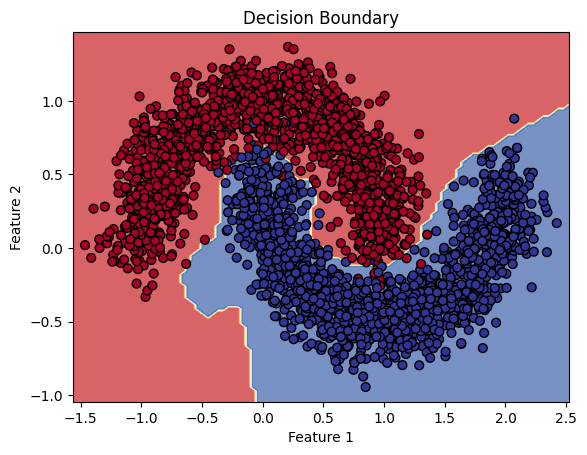

In [34]:
plot_2D_binary_decision_boundary(X,Y,my_model)